In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Reading the data
You might get a `DtypeWarning`; ignore it now, if necessary, deal with it later.

In [29]:
# Loading the raw dataset
df = pd.read_csv('../data/LendingClub_wi3435TU.csv')

C:\Users\denis\AppData\Local\Temp\ipykernel_14104\1303556865.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LendingClub_wi3435TU.csv')


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217452 entries, 0 to 217451
Columns: 124 entries, id to settlement_term
dtypes: float64(88), int64(1), object(35)
memory usage: 205.7+ MB


#### Loading the data dictionary
The field descriptions are read in as a Pandas data frame and then extended to a (Pandas) data frame `preview` for a first peek at the data.

In [31]:
pd.set_option('max_colwidth', 1200) # controls output width; might need adjustment
data_dictionary = pd.read_csv('LCDataDictionary.csv') # Loading in the data dictionary
data_dictionary = data_dictionary.rename(columns={'LoanStatNew': 'name', 'Description': 'description'})
data_dictionary.head()

,name,description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.


In [32]:
# generate preview names + dtypes + first values + descriptions
df_dtypes = pd.DataFrame(df.dtypes,columns=['dtypes'])
df_dtypes = df_dtypes.reset_index()
df_dtypes['name'] = df_dtypes['index']
df_dtypes = df_dtypes[['name','dtypes']]
df_dtypes['first value'] = df.loc[0].values
preview = df_dtypes.merge(data_dictionary, on='name',how='left')

In [33]:
pd.options.display.max_rows = 4000
preview

,name,dtypes,first value,description
0,id,int64,92807938,A unique LC assigned ID for the loan listing.
1,member_id,float64,NaN,A unique LC assigned Id for the borrower member.
2,loan_amnt,float64,7200.0,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
3,term,object,36 months,The number of payments on the loan. Values are in months and can be either 36 or 60.
4,int_rate,float64,11.49,Interest Rate on the loan
5,installment,float64,237.4,The monthly payment owed by the borrower if the loan originates.
6,grade,object,B,LC assigned loan grade
7,sub_grade,object,B5,LC assigned loan subgrade
8,emp_title,object,Health Information Specialist,The job title supplied by the Borrower when applying for the loan.*
9,emp_length,object,7 years,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.


## Features with a lot of missing values
A global investigation into the missing values, using `plt.hist` from Matplotlib.

In [34]:
# Overall fraction of null values in the data
(df.isnull().sum().sum())/(df.shape[0]*df.shape[1])

0.31231605135846074

Number of fields with more than 25% NAs: 39
Number of fields with less than 1%% NAs: 74


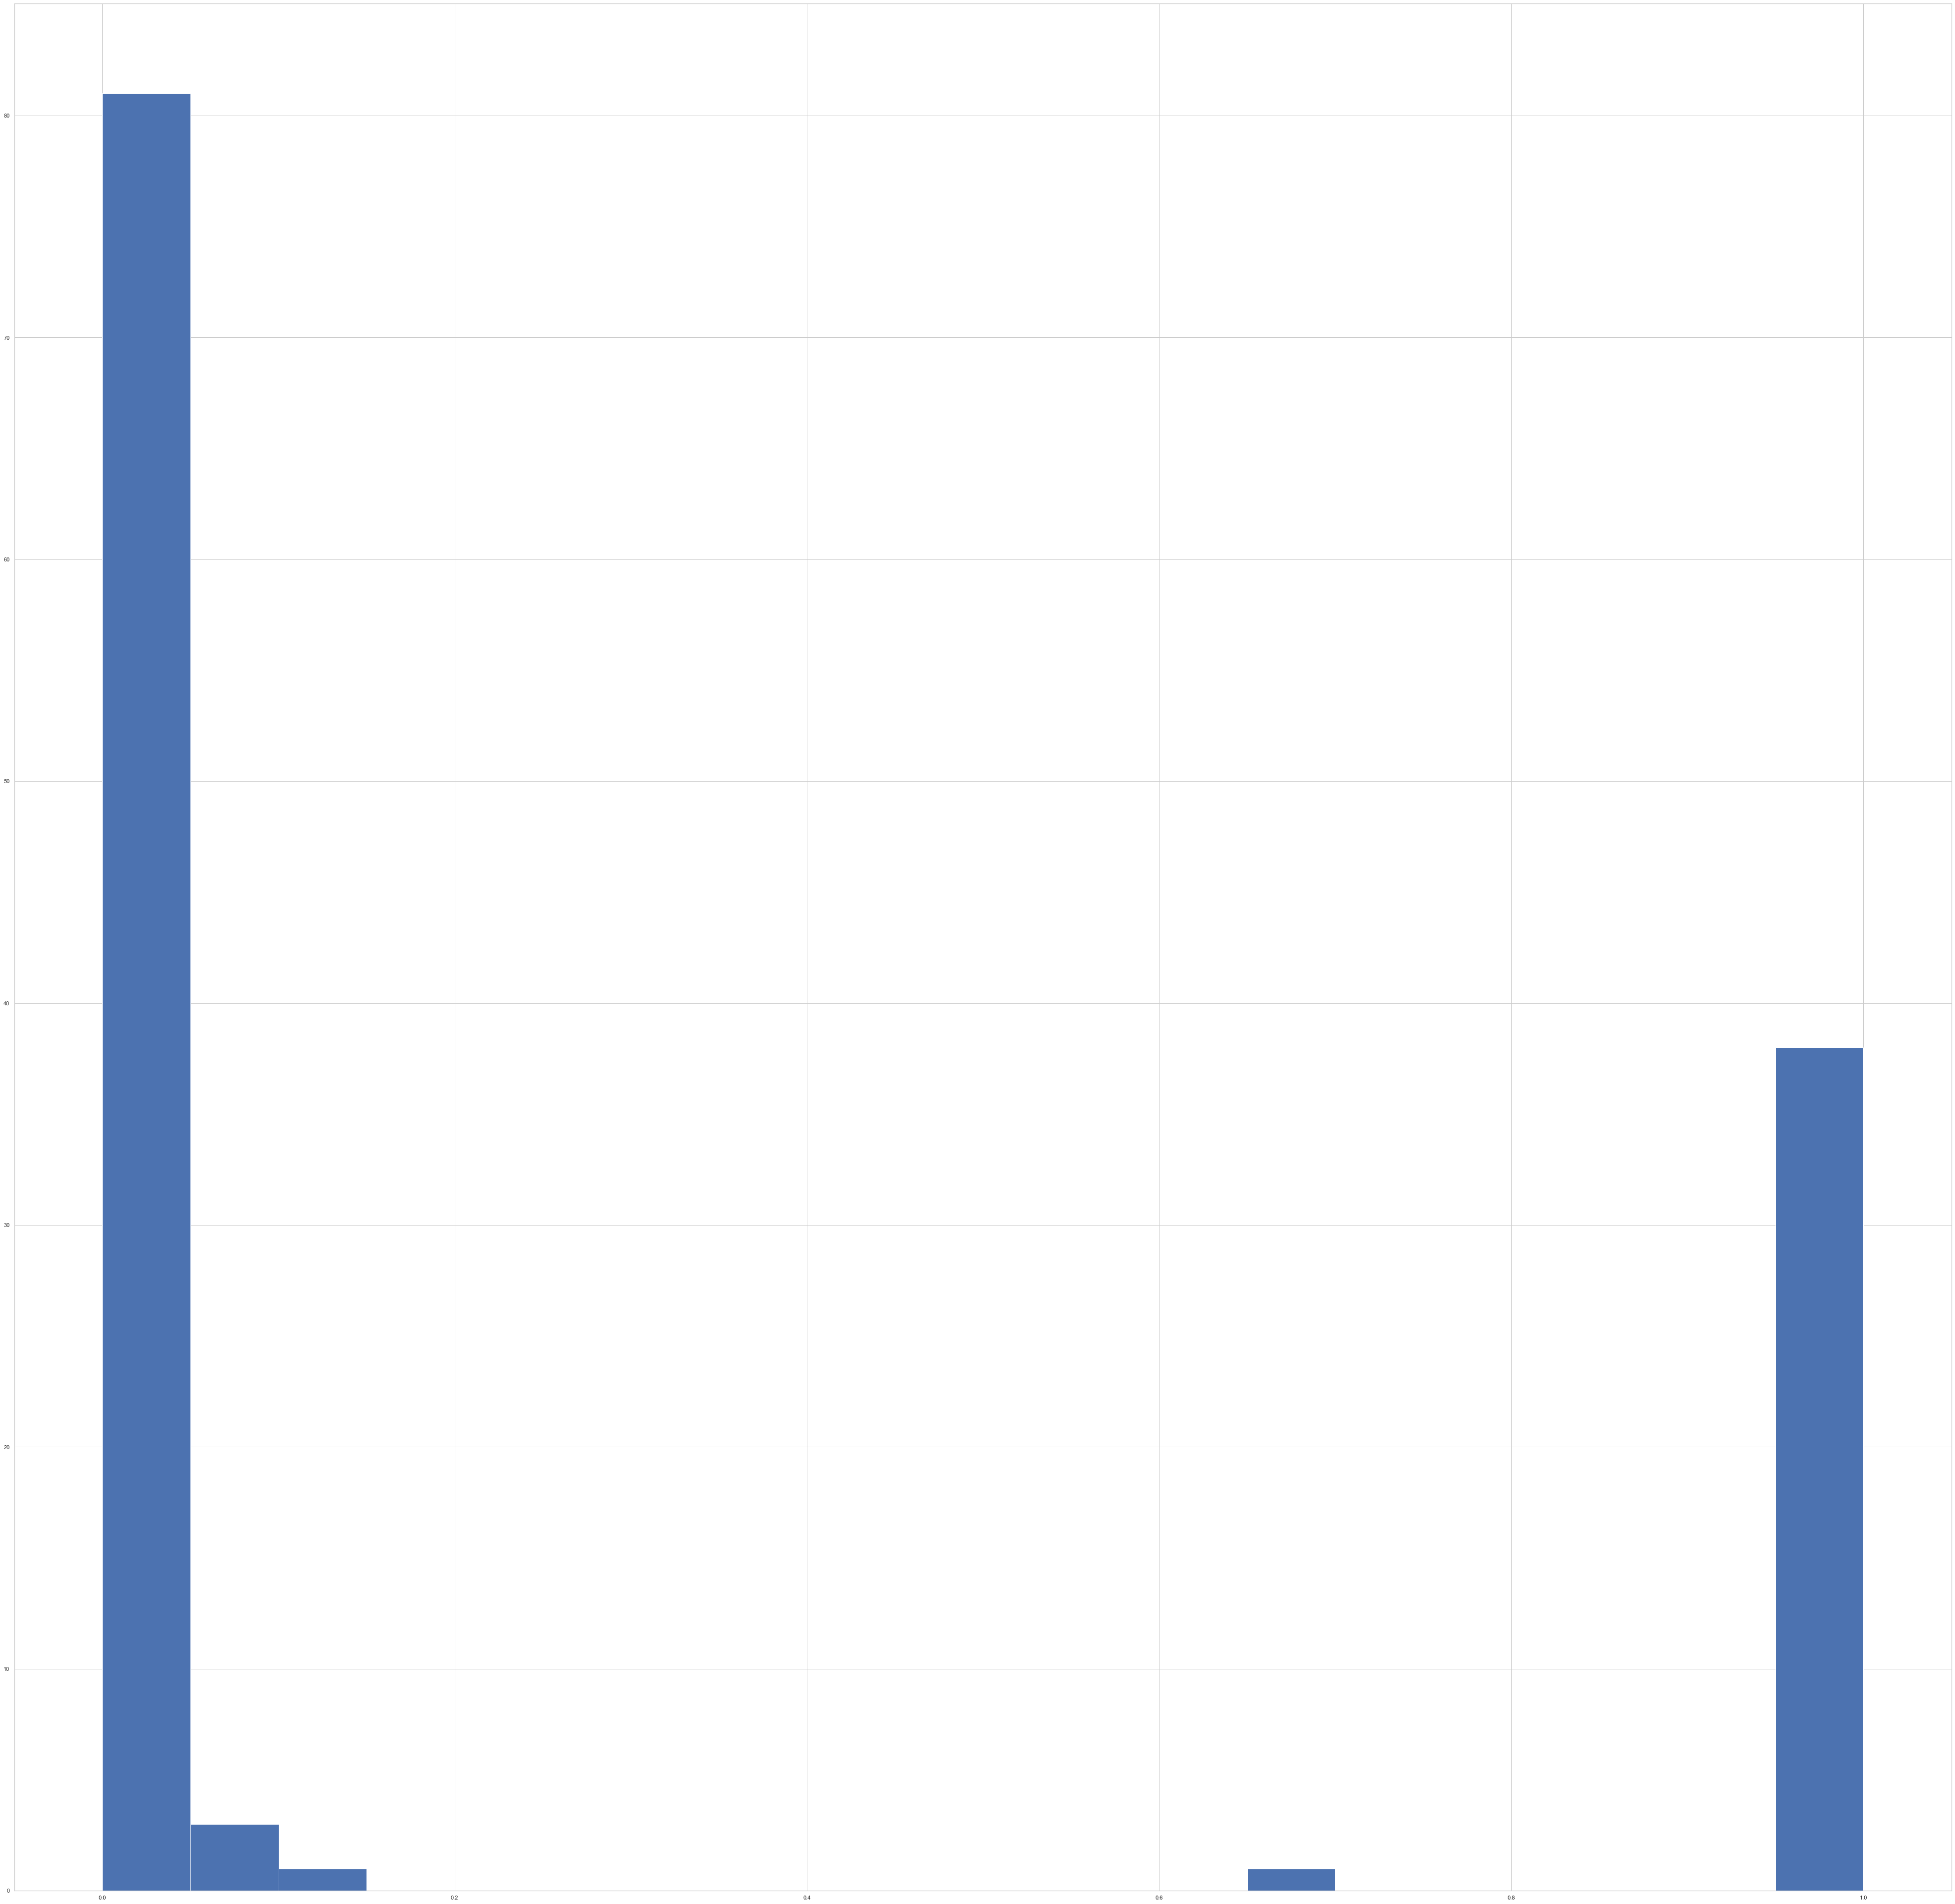

In [35]:
# create overview of distribution of NAs over the variables:
nullfrac= df.isnull().sum()/df.shape[0]
plt.hist(nullfrac,bins=20)
print("Number of fields with more than 25% NAs:", sum(nullfrac>0.25))
print("Number of fields with less than 1%% NAs:", sum(nullfrac<0.001))

In [36]:
# Example of how to drop the feature from a list
drop_list = ['member_id']
df.drop(drop_list, axis=1, inplace=True)

In [37]:
df.shape

(217452, 123)

## Filtering on loan_status

In [38]:
df['loan_status'].value_counts()

Fully Paid            112409
Current                67079
Charged Off            34358
Late (31-120 days)      2252
In Grace Period          885
Late (16-30 days)        461
Default                    8
Name: loan_status, dtype: int64

In [39]:
# value counts, this time fancy in a Pandas data frame
meaning = [
"Loan has been fully paid off.",
"Loan is up to date on current payments.",
"Loan for which there is no longer a reasonable expectation of further payments.",
"Loan hasn't been paid in 31 to 120 days (late on the current payment).",
"The loan is past due but still in the grace period of 15 days.",
"Loan hasn't been paid in 16 to 30 days (late on the current payment).",
"Loan is defaulted on and no payment has been made for more than 121 days."]
status, count = df["loan_status"].value_counts().index, df["loan_status"].value_counts().values
loan_statuses_explanation = pd.DataFrame({'Loan Status': status,'Count': count,'Meaning': meaning})[['Loan Status','Count','Meaning']]
loan_statuses_explanation

,Loan Status,Count,Meaning
0,Fully Paid,112409,Loan has been fully paid off.
1,Current,67079,Loan is up to date on current payments.
2,Charged Off,34358,Loan for which there is no longer a reasonable expectation of further payments.
3,Late (31-120 days),2252,Loan hasn't been paid in 31 to 120 days (late on the current payment).
4,In Grace Period,885,The loan is past due but still in the grace period of 15 days.
5,Late (16-30 days),461,Loan hasn't been paid in 16 to 30 days (late on the current payment).
6,Default,8,Loan is defaulted on and no payment has been made for more than 121 days.


In [40]:
# Example of how you might do this. Complete?
df = df[(df["loan_status"] == "Fully Paid") | (df["loan_status"] == "Charged Off") | (df["loan_status"] == "Default")]
mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0, "Default": 0}}
df = df.replace(mapping_dictionary)
df.shape

(146775, 123)

## Preventing leakage

In [41]:
# collect list of features that are not available at the application date
# next_pymnt_d as well but full of NANs so it will be filtered out later
drop_list1 = ['issue_d', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d']
df.drop(drop_list1, axis=1, inplace=True)

## Dropping features of no/little predictive value

In [42]:
# INCOMPLETE
# ALREADY DELETED - member_id
drop_list2 = ['id','disbursement_method', 'url', 'desc', 'zip_code', 'emp_title', 'grade', 'title', 'bc_open_to_buy', 'max_bal_bc', 'mths_since_recent_bc']
df.drop(drop_list2, axis=1, inplace=True)

## Unbalanced features

In [43]:
# an example of how to look at some value-counts
# application_type, policy_code, out_prncp, collections_12_mths_ex_med, chargeoff_within_12_mths, tax_liens, hardship_flag, debt_settlement_flag
# next_pymnt_d - mostly empty

# TOO MUCH OUTPUT
# We instead did it feature by feature
# for col in df.columns:
#     print(df[col].value_counts())
#     print()

In [44]:
# Dropping unbalanced features
drop_list3 = ['application_type', 'policy_code', 'out_prncp', 'collections_12_mths_ex_med', 
'chargeoff_within_12_mths', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']
df.drop(drop_list3, axis=1, inplace=True)

## Highly correlated features

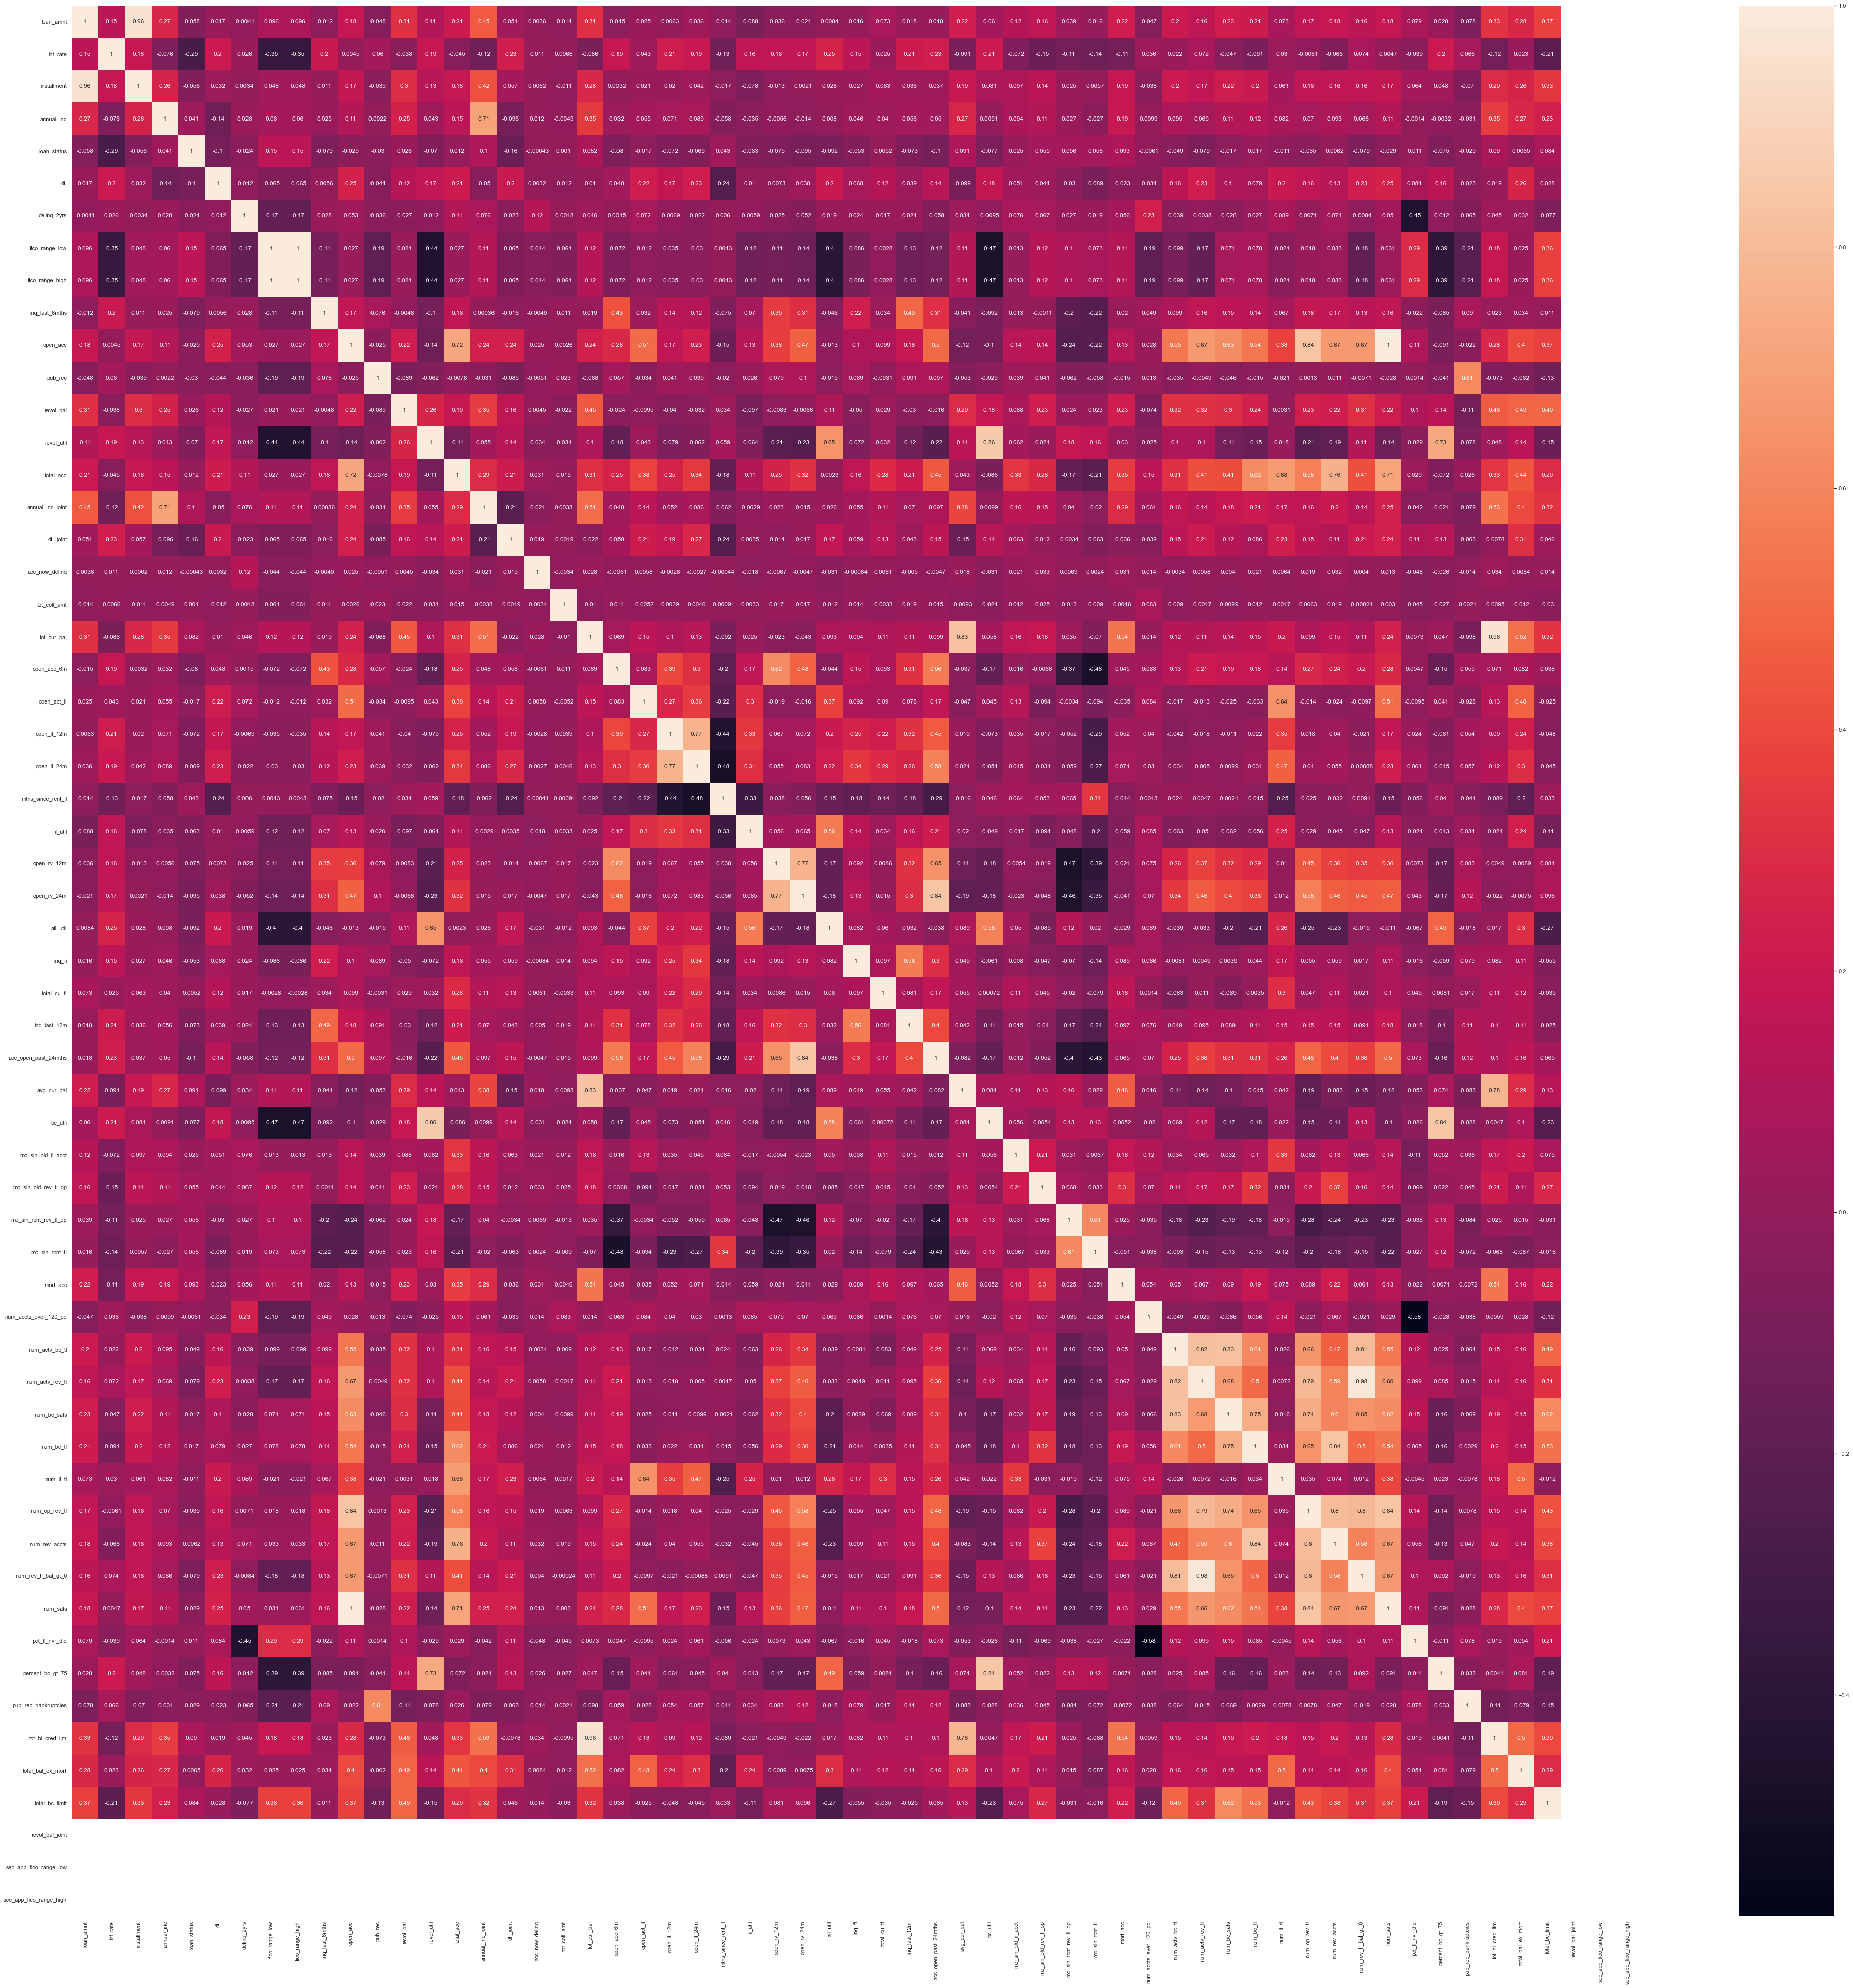

In [45]:
# Checking correlation and using heatmap to visualise it.
# First select a subset of the columns to keep the size of the correlation matrix low
# Output looks a bit strange, is it OK?
select = list(df.columns[0:70])     
dfsel = df[select]
sns.set(rc={'figure.figsize':(70,70)})
sns.set_style('whitegrid')
# Compute correlations and plot heatmap (exclude non-numeric features)
correlations = dfsel.corr()
sns.heatmap(correlations,annot=True)
plt.show()

# combine fico_range_low and fico_range_high into a new fico_range_avg/fico_avg feature
df['fico_range_avg'] = (df['fico_range_low'] + df['fico_range_high'] ) / 2
# drop features highly correlated with other features
drop_list4 = ['fico_range_low', 'fico_range_high', 'open_acc', 'num_op_rev_tl', 'installment', 'percent_bc_gt_75', 'revol_util', 'tot_hi_cred_lim', 'num_rev_tl_bal_gt_0', 
'open_rv_24m', 'num_accts_ever_120_pd', 'mo_sin_old_rev_tl_op']
df.drop(drop_list4, axis=1, inplace=True)

## Getting rid of the remaining missing values
Upon first running, before (many) features have been dropped, the list below might/will still contain a large number of feature, many with a large number of missing values. This might indicate you have not cleaned enough in the earlier stages.

In [46]:
df.shape

(146775, 89)

In [47]:
# Create dataframe of null-counts and look at the numbers
# This only makes sense when you have done most of the other cleaning
NAcount= df.isnull().sum()
hasNAs = NAcount[NAcount>0]
print("There are", len(hasNAs), "features that have missing values.")
b = pd.DataFrame(hasNAs,columns=['Number of null values'])
b.sort_values(by=['Number of null values'],ascending=False)

There are 53 features that have missing values.


,Number of null values
sec_app_open_acc,146775
sec_app_num_rev_accts,146775
sec_app_fico_range_low,146775
sec_app_fico_range_high,146775
sec_app_earliest_cr_line,146775
sec_app_inq_last_6mths,146775
sec_app_mort_acc,146775
sec_app_revol_util,146775
sec_app_open_act_il,146775
sec_app_chargeoff_within_12_mths,146775


In [48]:
drop_list5 = ['sec_app_fico_range_low', 'sec_app_open_acc', 'sec_app_inq_last_6mths', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_revol_util', 
'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_collections_12_mths_ex_med', 'sec_app_chargeoff_within_12_mths', 'sec_app_mths_since_last_major_derog', 
'revol_bal_joint', 'sec_app_mort_acc', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'hardship_type', 'hardship_reason', 
'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 
'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'dti_joint', 'verification_status_joint', 'annual_inc_joint', 'debt_settlement_flag_date', 'settlement_status', 
'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']
df.drop(drop_list5, axis=1, inplace=True)
df.shape # check dimensions

(146775, 52)

In [49]:
# REPLACE MISSING VALUES:
# emp_length: map NaNs to "< 1 year" as we concluded that NaNs might indicate unemployment
df["emp_length"].fillna("< 1 year", inplace=True)
# inq_last_6mths: map NaN to 0.0
df["inq_last_6mths"].fillna(0, inplace=True)
# il_util: map NaN to average
df["il_util"].fillna((df["il_util"].mean()), inplace=True)
# mths_since_rcnt_il
df["mths_since_rcnt_il"].value_counts(dropna=False)
# bc_util: map NaN to average
df["bc_util"].fillna((df["bc_util"].mean()), inplace=True)
# all_util: map NaN to average
df["all_util"].fillna((df["all_util"].mean()), inplace=True)
# open_acc_6m: map NaN to 0.0
df["open_acc_6m"].fillna(0.0, inplace=True)
# total_cu_tl: map NaN to 0.0
df["total_cu_tl"].fillna(0.0, inplace=True)
# inq_last_12m: map NaN to 0.0
df["inq_last_12m"].fillna(0.0, inplace=True)
# all_util: map NaN to floored mean
df["open_act_il"].fillna(math.floor(df["open_act_il"].mean()), inplace=True)
# open_il_12m: map NaN to 0.0 (median)
df["open_il_12m"].fillna(0.0, inplace=True)
# open_il_24m: map NaN to 0.0 (median)
df["open_il_24m"].fillna(0.0, inplace=True)
# open_rv_12m: map NaN to 0.0 (median)
df["open_rv_12m"].fillna(0.0, inplace=True)
# inq_fi: map NaN to 0.0 (median)
df["inq_fi"].fillna(0.0, inplace=True)
# dti: map NaN to average
df["dti"].fillna((df["all_util"].mean()), inplace=True)
# mths_since_rcnt_il: map NaN to 0.0 (median)
df["mths_since_rcnt_il"].fillna(0.0, inplace=True)
# mo_sin_old_il_acct: map NaN to 0.0 (median)
df["mo_sin_old_il_acct"].fillna(0.0, inplace=True)

## Dates
There may or may not be any date features left. Let's check the categorical features still present.

In [50]:
print("Data types and their frequency\n{}".format(df.dtypes.value_counts()))

Data types and their frequency
float64    42
object      9
int64       1
dtype: int64


In [51]:
# generate list of remaining categorical features
obcols = list(df.columns[df.dtypes == 'object'])
obcols

['term',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status']

In [52]:
for col in obcols:
    print(df[col].value_counts())

# map earliest_cr_line to difference in year between the date and latest one in the dataset (2013 in this case)
df['earliest_cr_line'] = list(map(lambda d: 2013 - int(str(d)[-4:]), df['earliest_cr_line']))

 36 months    116160
 60 months     30615
Name: term, dtype: int64
B5    10375
C1    10346
B4     9599
C2     8870
B3     8696
C4     8370
C3     8223
B2     7960
B1     7917
C5     7561
A1     6740
A5     5560
D1     5263
A4     5002
D2     4941
A2     3729
D3     3687
D4     3603
A3     3530
D5     2908
E1     2670
E3     1866
E2     1847
E4     1610
E5     1371
F1     1064
F2      812
F3      612
F4      552
F5      474
G1      314
G2      246
G3      198
G4      145
G5      114
Name: sub_grade, dtype: int64
10+ years    49623
< 1 year     20606
2 years      13661
3 years      12009
1 year       10076
5 years       9018
4 years       8743
8 years       6421
6 years       6127
9 years       5738
7 years       4753
Name: emp_length, dtype: int64
MORTGAGE    71423
RENT        57610
OWN         17708
ANY            34
Name: home_ownership, dtype: int64
Source Verified    61685
Verified           43156
Not Verified       41934
Name: verification_status, dtype: int64
debt_consolidation   

In [53]:
# this is crummy code ... sorry
pd.set_option('max_colwidth', 20)
object_columns_df = df.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

term                            36 months
sub_grade                              B5
emp_length                        7 years
home_ownership                       RENT
verification_status          Not Verified
purpose                debt_consolidation
addr_state                             NY
initial_list_status                     w
Name: 0, dtype: object


In [54]:
df.shape

(146775, 52)